## Scraping from Edmunds

In [ ]:
!pip install selenium
!apt-get-q update #Used to handle installation and removal of softwares and libraries
!apt install-yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin #copying the chromedriver executable to the generic system path directory for easy access
import sys
sys.path.insert(0,'usr\lib\chromium-browser\chromedriver') #adding the chromedriver directory to the list of directories to search for python modules and packages

#importing the required modules and setting up the chrome options
from selenium import webdriver
from selenium.webdriver.common.by import By

chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless") #running chrome browser in a headless mode without displaying graphical user interface since we want to perform automated web-scraping
chrome_options.add_argument("--no-sandbox")#disabling the sandbox security feature of chrome browser
chrome_options.add_argument("--disable-dev-shm-usage") #disabling /dev/shm temperory directory since shared memory is not necessary while running in headless mode.

In [ ]:
import pandas as pd

#extracting information from multiple webpages
driver=webdriver.Chrome(options=chrome_options)

url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'

user_id=[]
date=[]
comment=[]

for i in range(1,121):  #working on old data
  url_next=url+"/p"+str(i)
  driver.get(url_next)
  elements=driver.find_elements(by=By.CLASS_NAME,value="Comment") #extracting all the elements associated with the class name "comment"
  for element in elements:
    temp_id=(element.find_element(by=By.CLASS_NAME,value="Author")).text #extracting the user name
    temp_date=(element.find_element(by=By.TAG_NAME,value="time")).text #extracting the date object
    temp_comment=(element.find_element(by=By.CLASS_NAME,value="Item-Body")).text #extracting the comment

    if temp_comment.strip(): #checks and skips including empty comments to the csv file
      user_id.append(temp_id)
      date.append(temp_date)
      comment.append(temp_comment)

df2 = pd.DataFrame({"User_ID":user_id,
                    "Date":date,
                    "Comment":comment
                    })

In [ ]:
df2.to_csv("oldposts_data.csv")
!ls
from google.colab import files
files.download("oldposts_data.csv")

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>About the dataset</b></font>
    
   <font color="black" face="verdana" size="3">We have scraped the oldest posts from the Edmunds - Entry level luxury car forum (https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans). Our dataset has posts dated from March 2002 to October 2006. </font>
</div>

## TASK A: Top 100 word & Zipf's Law

In [1]:
import pandas as pd
import numpy as np

# Load the models and brands mapping
mapping_df = pd.read_csv('car_models_and_brands.csv')

# Load the data from Data Scrapper Code
data_df = pd.read_csv('oldposts_data.csv')

# Create a dictionary for mapping models to brands
model_to_brand = {}
for _, row in mapping_df.iterrows():
    brand = row['Brand']
    models = row['Model'].split('|')
    for model in models:
        model_to_brand[model] = brand

model_to_brand['330i'] = 'bmw'
model_to_brand['325i'] = 'bmw'
model_to_brand['rx'] = 'lexus'
model_to_brand['ls'] = 'lexus'
model_to_brand['gs'] = 'lexus'
model_to_brand['es'] = 'lexus'
model_to_brand['g35'] = 'infiniti'

del model_to_brand['mercedes']
model_to_brand['passat'] = 'volkswagen'

brand_fil = list(set(model_to_brand.values()))


In [2]:
rem_brand = ["car","seat","sedan","problem"]

brand_fil = [word for word in brand_fil if word not in rem_brand]
print(brand_fil)
data_df

['suzuki', 'mazda', 'hyundai.', 'hyundai', 'toyata', 'mitsubishi', 'infiniti', 'nissan', 'toyota', 'chevrolet', 'chrysler', 'honda', 'hyundai,', 'bmw', 'ford', 'volkswagen', 'dodge', 'mercedes', 'lexus', 'cadillac', 'buick', 'pontiac', 'volvo', 'lincoln', 'mercury', 'audi', 'acura', 'kia.', 'subaru', 'saturn', 'kia', 'hyndai kia', 'nissan.']


,Unnamed: 0,User_ID,Date,Comment
0,0,merc1,Mar-02,I personally think that with a few tweaks the ...
1,1,fredvh,Mar-02,I am debating a new purchase and these two are...
2,2,blueguydotcom,Mar-02,"Great handling, RWD, excellent engine and the ..."
3,3,hungrywhale,Mar-02,And no manual tranny. That may not matter to y...
4,4,riez,Mar-02,One beauty of BMW 3 Series is that there are s...
...,...,...,...,...
5980,5980,brightness04,Oct-06,"When I bought in 1988, fixed mortgage rates we..."
5981,5981,qbrozen,Oct-06,You won't get an argument from me.\n\nI'd neve...
5982,5982,qbrozen,Oct-06,"As Rocky point out, this is about SEDANS. Last..."
5983,5983,rockylee,Oct-06,"Rocky, I don't know how you get these ridiculo..."


In [3]:
data_df = data_df.drop(columns='Unnamed: 0')

In [4]:
data_df.head()

,User_ID,Date,Comment
0,merc1,Mar-02,I personally think that with a few tweaks the ...
1,fredvh,Mar-02,I am debating a new purchase and these two are...
2,blueguydotcom,Mar-02,"Great handling, RWD, excellent engine and the ..."
3,hungrywhale,Mar-02,And no manual tranny. That may not matter to y...
4,riez,Mar-02,One beauty of BMW 3 Series is that there are s...


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import re

# Extract the comment column
comments = data_df[data_df['Comment'].apply(lambda x: isinstance(x, str))]['Comment']

# Tokenize and preprocess the comments (remove punctuation and convert to lowercase)
def preprocesstext(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    return words

# Tokenize and preprocess the comments
all_words = []
for comment in comments:
    words = preprocesstext(comment)
    all_words.extend(words)

# Calculate word frequencies
word_frequencies = pd.Series(all_words).value_counts()
word_frequencies

the             32318
a               15058
and             12926
i               12556
to              12222
                ...  
amendment           1
constitution        1
farthest            1
millisecond         1
unpractical         1
Length: 22936, dtype: int64

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Implications from above table</b></font>
    
   <font color="black" face="verdana" size="3">Upon examining the tables presented above, it becomes evident that the most frequently occurring word within our dataset of reviews is none other than the ubiquitous word "the," which makes a appearance nearly 30,000 times. This outcome resonates with our initial expectations, as "the" tends to hold the top spot as the most prevalent word in a wide array of datasets. Following closely behind "the" in terms of frequency are the words "a" and "and."</font>
</div>

### Testing ZIPF's Law for top 100 most common words

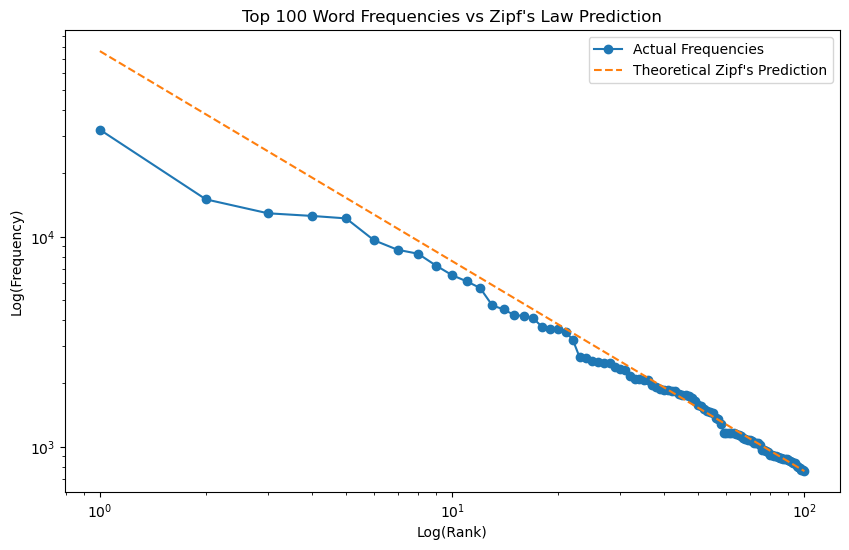

In [6]:
word_frequencies_100 = word_frequencies.head(100)

ranks = np.arange(1,len(word_frequencies_100)+1)

zipf_const = ranks[-1] * word_frequencies_100[-1]
theoretical_freq = zipf_const / ranks

# Plot the actual frequencies vs theoretical frequencies
plt.figure(figsize=(10, 6))
plt.plot(ranks, word_frequencies_100, marker='o', label="Actual Frequencies")
plt.plot(ranks, theoretical_freq, linestyle='--', label="Theoretical Zipf's Prediction")
plt.xscale('log')
plt.yscale('log')
plt.title("Top 100 Word Frequencies vs Zipf's Law Prediction")
plt.xlabel("Log(Rank)")
plt.ylabel("Log(Frequency)")
plt.legend()
plt.show()


<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Implications from above Graph</b></font>
    
   <font color="black" face="verdana" size="3">Based on the observations from the graph, it appears that the actual frequencies closely align with the theoretical predictions, suggesting a potential adherence to Zipf's law. To delve deeper into this analysis, we will employ a linear regression model to assess the goodness of fit. In doing so, we aim to compare the slopes and R-squared values to quantify the degree of alignment between the observed data and the Zipf's law predictions. This will allow us to gain a more precise understanding of the relationship between the variables and assess the law's applicability to our dataset.</font>
</div>

### Empirically testing Zipf's law using Linear Regression

In [7]:
import statsmodels.api as sm

normaliz_fre = word_frequencies_100/zipf_const

logrank = np.log(ranks)
logfrequency = np.log(normaliz_fre)

model = sm.OLS(logrank, logfrequency).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          5.009e+04
Date:                Sun, 10 Sep 2023   Prob (F-statistic):                   1.01e-135
Time:                        18:18:56   Log-Likelihood:                          37.282
No. Observations:                 100   AIC:                                     -72.56
Df Residuals:                      99   BIC:                                     -69.96
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Implications from OLS Summary</b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   Based on the results obtained from the regression analysis of the expression $\log{r} = \theta\log{\frac{f}{f_nr_n}} + \epsilon$, we can confidently conclude that $\theta$ i.e, the coefficient of our linear model is approximately -1 (-0.9873). This alignment with Zipf's law is significant and suggests that the observed data adheres closely to the principles of this empirical law.

   The high $R^2$ value of 0.998 further underscores the model's suitability for describing the data. This coefficient of determination indicates that a substantial portion of the data's variability is effectively captured by the model, affirming its strong fit to the dataset in line with Zipf's law.
   
   Moreover, the p-value of 0 essentially dismisses the null hypothesis that $\theta = 0$. This statistical significance underscores that the observed $\theta$ value is markedly different from zero, reinforcing the empirical support for Zipf's law in the analyzed dataset.
   In summary, the regression results robustly affirm the presence of Zipf's law characteristics in the dataset, with $\theta \approx -1$, an impressive $R^2$ value, and a p-value indicating statistical significance.</font>
</div>

## TASK B: Word frequency table after removing stop words

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords (you only need to do this once)
nltk.download('stopwords')

# Extract the comment column
comments = data_df[data_df['Comment'].apply(lambda x: isinstance(x, str))]['Comment']

# Get the NLTK English stop words
stop_words = set(stopwords.words('english'))

# Tokenize and preprocess the comments (remove punctuation, convert to lowercase, and remove stop words)
def preprocesstext(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    nswords = [word for word in words if word not in stop_words]
    nswords = [model_to_brand.get(word, word) for word in nswords]
    return list(set(nswords))

# Tokenize and preprocess the comments, removing stop words
words_nostop = []
for comment in comments:
    words = preprocesstext(comment)
    words_nostop.extend(words)

# Calculate word frequencies
words_nostop_freq = pd.Series(words_nostop).value_counts()

wnf_df = pd.DataFrame(words_nostop_freq)
wnf_df = wnf_df.reset_index()
wnf_df = wnf_df.rename(columns={'index': 'words', 0: 'frequency'})

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/uditdhand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


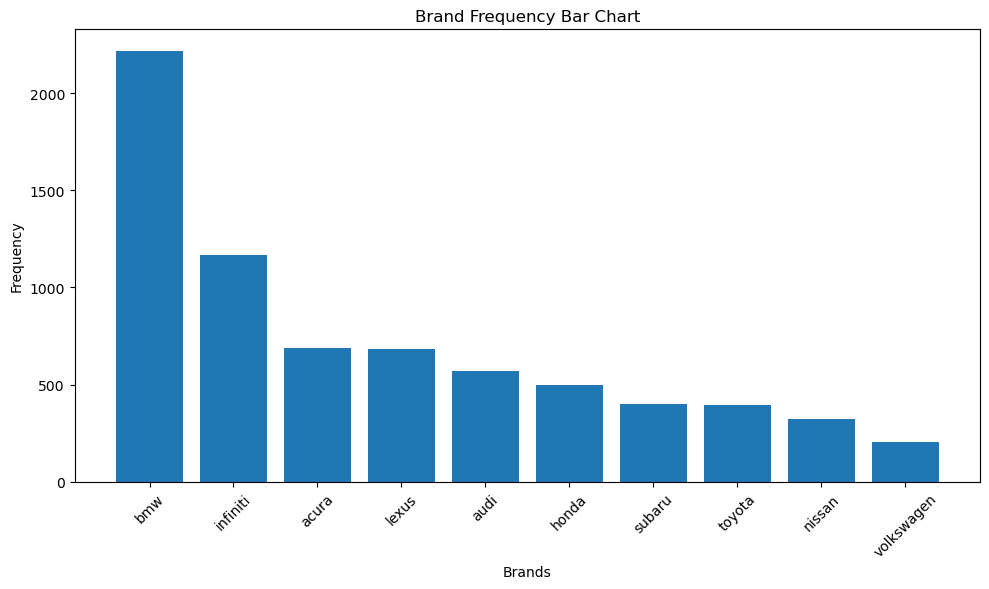

In [9]:
top_bd_df = wnf_df[wnf_df['words'].isin(brand_fil)]

plt.figure(figsize=(10, 6))
plt.bar(top_bd_df['words'].head(10), top_bd_df['frequency'].head(10))
plt.xlabel('Brands')
plt.ylabel('Frequency')
plt.title('Brand Frequency Bar Chart')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

plt.show()

In [10]:
top_10_df = top_bd_df.head(10)
top_10_df

,words,frequency
1,bmw,2217
7,infiniti,1167
26,acura,688
27,lexus,685
40,audi,568
49,honda,496
71,subaru,403
75,toyota,397
107,nissan,322
220,volkswagen,204


<div style="background-color: #f0f8ff; padding: 10px;">

<font color="black" face="verdana" size="3"><b>Implications from Top Brand Analysis</b></font>
    
<font color="black" face="verdana" size="3">
Following our analysis, it's evident that BMW emerges as the most frequently mentioned automotive brand in our dataset, making appearances in over 2,000 reviews sourced from Edmunds. This notable presence is closely trailed by Infiniti and Acura.
    
It's important to note that our dataset exclusively covers data from 2000 - 2006. Consequently, direct comparisons with more recent trends may not be feasible due to this temporal limitation. </font>

</div>

## TASK C: LIFT Analysis

In [11]:
def preprocesstextdistance(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = re.findall(r'\b\w+\b', text.lower())  # Tokenize and convert to lowercase
    nswords = [word for word in words if word not in stop_words]
    nswords = [model_to_brand.get(word, word) for word in nswords]
    return nswords

In [12]:
token_df = pd.DataFrame(comments)
token_df['Tokenized_Message'] = token_df['Comment'].map(preprocesstext)
token_df['Tokenized_MessageDistance'] = token_df['Comment'].map(preprocesstextdistance)


In [13]:
word_distance = 9

def distance_thresh(words_list, word1, word2, max_distance):
    indices_word1 = [i for i, word in enumerate(words_list) if word == word1]
    indices_word2 = [i for i, word in enumerate(words_list) if word == word2]
    for idx1 in indices_word1:
        for idx2 in indices_word2:
            if abs(idx1 - idx2) <= max_distance:
                return True
    return False

def lift_analysis(data,data_dist,word_A,word_B,max_distance):
    if (word_A == word_B):
        return '-'
    else:
        N = data.shape[0]
        N_A = sum(1 for review in data if word_A in review)
        N_B = sum(1 for review in data if word_B in review)
        N_A_and_B = sum(1 for review in data_dist if distance_thresh(review, word_A, word_B, max_distance) and word_A in review and word_B in review)
    
        lift = (N * N_A_and_B) / (N_A * N_B)

        return np.round(lift,4)

df_lift = []

for index, brand1 in top_10_df.iterrows():
    for index,brand2 in top_10_df.iterrows():
        df_lift.append(lift_analysis(token_df['Tokenized_Message'],token_df['Tokenized_MessageDistance'],brand1['words'],brand2['words'],word_distance))


In [14]:
import numpy as np
lift_np = np.reshape(df_lift,(10,10))
lift_df = pd.DataFrame(data= lift_np)
for i in range(10):
    lift_df = lift_df.rename(columns = {i: top_10_df.iloc[i, 0]})
    lift_df = lift_df.rename(index = {i: top_10_df.iloc[i, 0]})
lift_df


,bmw,infiniti,acura,lexus,audi,honda,subaru,toyota,nissan,volkswagen
bmw,-,0.9924,0.7416,1.0444,1.2215,0.479,0.288,0.4352,0.4695,0.5823
infiniti,0.9924,-,1.3194,1.2653,0.9481,0.5066,0.42,0.323,1.0512,0.5531
acura,0.7416,1.3194,-,1.5874,1.164,1.3855,1.8132,0.3506,0.7835,0.5117
lexus,1.0444,1.2653,1.5874,-,1.1537,0.4228,0.2385,1.1664,0.5427,0.2998
audi,1.2215,0.9481,1.164,1.1537,-,0.3824,0.4968,0.345,0.2945,2.4276
honda,0.479,0.5066,1.3855,0.4228,0.3824,-,0.3892,3.6473,2.6232,0.7098
subaru,0.288,0.42,1.8132,0.2385,0.4968,0.3892,-,0.4115,0.4612,0.5824
toyota,0.4352,0.323,0.3506,1.1664,0.345,3.6473,0.4115,-,2.7623,1.2563
nissan,0.4695,1.0512,0.7835,0.5427,0.2945,2.6232,0.4612,2.7623,-,1.4578
volkswagen,0.5823,0.5531,0.5117,0.2998,2.4276,0.7098,0.5824,1.2563,1.4578,-


## Task D: MDS Plot

In [19]:
lift_df = lift_df.replace(to_replace='-',value=1)
lift_df = lift_df.astype(float)
lift_df

,bmw,infiniti,acura,lexus,audi,honda,subaru,toyota,nissan,volkswagen
bmw,1.0000,0.9924,0.7416,1.0444,1.2215,0.4790,0.2880,0.4352,0.4695,0.5823
infiniti,0.9924,1.0000,1.3194,1.2653,0.9481,0.5066,0.4200,0.3230,1.0512,0.5531
acura,0.7416,1.3194,1.0000,1.5874,1.1640,1.3855,1.8132,0.3506,0.7835,0.5117
lexus,1.0444,1.2653,1.5874,1.0000,1.1537,0.4228,0.2385,1.1664,0.5427,0.2998
audi,1.2215,0.9481,1.1640,1.1537,1.0000,0.3824,0.4968,0.3450,0.2945,2.4276
honda,0.4790,0.5066,1.3855,0.4228,0.3824,1.0000,0.3892,3.6473,2.6232,0.7098
subaru,0.2880,0.4200,1.8132,0.2385,0.4968,0.3892,1.0000,0.4115,0.4612,0.5824
toyota,0.4352,0.3230,0.3506,1.1664,0.3450,3.6473,0.4115,1.0000,2.7623,1.2563
nissan,0.4695,1.0512,0.7835,0.5427,0.2945,2.6232,0.4612,2.7623,1.0000,1.4578
volkswagen,0.5823,0.5531,0.5117,0.2998,2.4276,0.7098,0.5824,1.2563,1.4578,1.0000


In [20]:
from sklearn.manifold import MDS

def invert_value(x):
    if x == 0:
        return np.NaN
    return 1/x

lift_df_inv = lift_df.applymap(invert_value)

lift_df_inv = lift_df_inv.replace(to_replace=np.NaN,value=200)

for i in range(len(lift_df_inv)):
    for j in range(len(lift_df_inv)):
            lift_df_inv.iloc[i, j] = lift_df_inv.iloc[i, j]  


lift_df_inv

,bmw,infiniti,acura,lexus,audi,honda,subaru,toyota,nissan,volkswagen
bmw,1.000000,1.007658,1.348436,0.957488,0.818666,2.087683,3.472222,2.297794,2.129925,1.717328
infiniti,1.007658,1.000000,0.757920,0.790326,1.054741,1.973944,2.380952,3.095975,0.951294,1.807991
acura,1.348436,0.757920,1.000000,0.629961,0.859107,0.721761,0.551511,2.852253,1.276324,1.954270
lexus,0.957488,0.790326,0.629961,1.000000,0.866776,2.365184,4.192872,0.857339,1.842639,3.335557
audi,0.818666,1.054741,0.859107,0.866776,1.000000,2.615063,2.012882,2.898551,3.395586,0.411929
honda,2.087683,1.973944,0.721761,2.365184,2.615063,1.000000,2.569373,0.274175,0.381214,1.408848
subaru,3.472222,2.380952,0.551511,4.192872,2.012882,2.569373,1.000000,2.430134,2.168257,1.717033
toyota,2.297794,3.095975,2.852253,0.857339,2.898551,0.274175,2.430134,1.000000,0.362017,0.795988
nissan,2.129925,0.951294,1.276324,1.842639,3.395586,0.381214,2.168257,0.362017,1.000000,0.685965
volkswagen,1.717328,1.807991,1.954270,3.335557,0.411929,1.408848,1.717033,0.795988,0.685965,1.000000


In [21]:
#perform multi-dimensional scaling
mds = MDS(random_state=0)
scaled_df = mds.fit_transform(lift_df_inv)


/Users/uditdhand/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/uditdhand/anaconda3/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


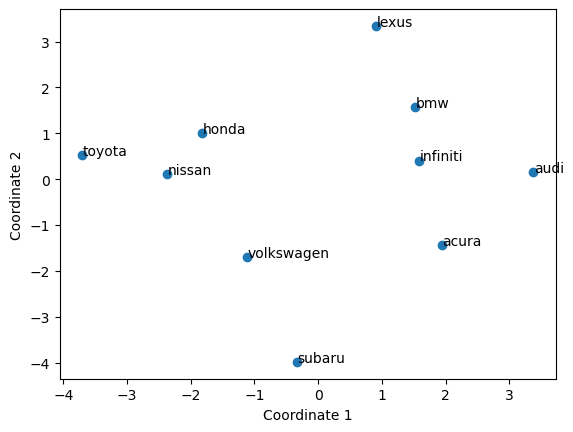

In [22]:
import matplotlib.pyplot as plt

#create scatterplot
plt.scatter(scaled_df[:,0], scaled_df[:,1])

#add axis labels
plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')

#add lables to each point
for i, txt in enumerate(top_10_df['words']):
    plt.annotate(txt, (scaled_df[:,0][i]+.01, scaled_df[:,1][i]))

#display scatterplot
plt.show()

## TASK E: Insights from LIFT and MDS Plot

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Insights from Lift Analysis</b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   [WRITE HERE]

   [WRITE HERE]
   
   [WRITE HERE]</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Insights from MDS plot</b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   [WRITE HERE]

   [WRITE HERE]
   
   [WRITE HERE]</font>
</div>

## Task F: Attributes

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Approach:</b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   To identify the five most frequently mentioned attributes or features of cars, we will analyze the top words without stopwords in order to determine the most common attributes or features of cars. We will then compile a list of these attributes and proceed with our analysis accordingly.</font>
</div>

In [141]:
wnf_df.iloc[40:80,:]

,words,frequency
40,audi,568
41,go,554
42,series,538
43,engine,517
44,buy,516
45,could,508
46,going,504
47,great,503
48,sure,500
49,honda,496


In [150]:
top_attributes = ['performance', 'price', 'engine', 'handling', 'power']

<div style="background-color: #f0f8ff; padding: 10px;">
    
   <font color="black" face="verdana" size="2.75"> 
   
   The listed attributes are the top occurring words that represent features and attributes of cars. While words like "interior" and "luxury" also had high frequencies in discussions about cars, we believe the attributes listed above align more closely with evaluating a car's abilities and characteristics. </font>
</div>

In [172]:
top5_att_fre = wnf_df[wnf_df['words'].isin(top_attributes)]
top5_att_fre

,words,frequency
18,performance,797
31,price,654
43,engine,517
55,handling,467
64,power,427


In [277]:
df_lift_att = []
for index, brand1 in top_10_df.iterrows():
    for index,attr in top5_att_fre.iterrows():
        df_lift_att.append(lift_analysis(token_df['Tokenized_Message'],token_df['Tokenized_MessageDistance'],brand1['words'],attr['words'],9))

In [278]:
lift_np = np.reshape(df_lift_att,(10,5))
lift_df_att = pd.DataFrame(data= lift_np)
for i in range(10):
    lift_df_att = lift_df_att.rename(index = {i: top_10_df.iloc[i, 0]})
for i in range(5):  
    lift_df_att = lift_df_att.rename(columns = {i: top5_att_fre.iloc[i, 0]})
lift_df_att

,performance,price,engine,handling,power
bmw,0.7147,0.6605,0.5796,0.7226,0.5564
infiniti,0.5534,0.7136,0.6349,0.5711,0.7447
acura,0.4693,0.4123,0.3365,0.4284,0.6316
lexus,0.5810,0.3607,0.5070,0.5613,0.2455
audi,0.3437,0.4350,0.5299,0.5415,0.7156
honda,0.4542,0.4982,0.3268,0.2842,0.3391
subaru,0.5590,0.3406,0.3734,0.3180,0.5565
toyota,0.6620,0.3458,0.3499,0.8393,0.4590
nissan,0.3965,0.3695,0.5752,0.2388,0.8271
volkswagen,0.2209,0.3140,0.3972,0.5654,0.8932


In [279]:
for index, row in lift_df_att.iterrows():
    sorted_attributes = row[1:].sort_values(ascending=False)
    print(f"Brand: {index}, Top Attributes: {', '.join(sorted_attributes.index)}")

Brand: bmw, Top Attributes: handling, price, engine, power
Brand: infiniti, Top Attributes: power, price, engine, handling
Brand: acura, Top Attributes: power, handling, price, engine
Brand: lexus, Top Attributes: handling, engine, price, power
Brand: audi, Top Attributes: power, handling, engine, price
Brand: honda, Top Attributes: price, power, engine, handling
Brand: subaru, Top Attributes: power, engine, price, handling
Brand: toyota, Top Attributes: handling, power, engine, price
Brand: nissan, Top Attributes: power, engine, price, handling
Brand: volkswagen, Top Attributes: power, handling, engine, price


<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Insights from Attribute Analysis </b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   [WRITE HERE]

   [WRITE HERE]
   
   [WRITE HERE]</font>
</div>

## Task G: What advice will you give to your client from Task F?

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Recommendations from Attribute Analysis </b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   [WRITE HERE]

   [WRITE HERE]
   
   [WRITE HERE]</font>
</div>

## TASK H: Most Aspirational Brands

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Approach:</b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   To determine the most aspirational brand, we will begin by compiling a list of words and phrases that convey a person's aspirations towards owning a particular brand. After creating this list, we will tally the occurrences of these words and phrases within individuals' reviews, specifically those reviews mentioning the brand of interest. To enhance the robustness of our analysis, we will implement a maximum word distance constraint, ensuring that the words or phrases must be mentioned within close proximity to the brand reference in the review text. </font>
</div>

In [248]:
aspirational_words_st = [
    'buy', 'love', 'crave', 'seek', 'envy', 'pursue', 'long', 'aim',
    'endeavor', 'lust', 'adore', 'strive', 'eager', 'passionate', 'obsess',
    'itch', 'pine', 'fancy', 'relish', 'imagine', 'inspired', 'infatuated',
    'worship', 'keen', 'drive', 'ride', 'rave', 'ache', 'beg', 'prized', 'ultimate',
    'prime', 'essential', 'priority', 'target', 'wannabe', 'prize', 'urge',
    'enthusiastic', 'dream', 'must-have', 'luxury', 'covet', 'yearn',
    'luxurious', 'top', 'best', 'elite', 'high-end', 'premier', 'splurge', 'aspire',
    'prestige', 'exclusive', 'status', 'cherish', 'desire', 'top-tier', 'flagship', 'benchmark',
    'standard', 'highly', 'pinnacle', 'wish', 'dream',
    'venerate', 'admire', 'epitome', 'symbol', 'gold', 'crème', 'quintessential',
    'hallmark', 'class', 'idolize', 'legendary', 'fawn', 'swoon', 'ultimate', 'symbol', 'represent',
    'ultimate', 'dream', 'obsessed', 'thinking', 'ideal', 'dream',
    'fantasize', 'long', 'love',  'heels', 'smitten',
    'awe', 'wishlist',
    'pride', 'owning',
    'top-notch', 'beauty',
    'showstopper', 'breath-taking', 'mesmerized'
]
aspirational_words = list(set(aspirational_words_st))
aspirational_words.remove('drive')
aspirational_words

['yearn',
 'desire',
 'thinking',
 'pursue',
 'standard',
 'venerate',
 'ideal',
 'urge',
 'wishlist',
 'ache',
 'strive',
 'wannabe',
 'beg',
 'swoon',
 'cherish',
 'smitten',
 'aspire',
 'endeavor',
 'top-tier',
 'mesmerized',
 'love',
 'itch',
 'symbol',
 'luxury',
 'obsessed',
 'owning',
 'prime',
 'hallmark',
 'rave',
 'obsess',
 'target',
 'priority',
 'crème',
 'eager',
 'covet',
 'prized',
 'top-notch',
 'passionate',
 'epitome',
 'highly',
 'pine',
 'infatuated',
 'envy',
 'wish',
 'pinnacle',
 'represent',
 'showstopper',
 'enthusiastic',
 'breath-taking',
 'admire',
 'awe',
 'keen',
 'top',
 'relish',
 'must-have',
 'aim',
 'inspired',
 'legendary',
 'seek',
 'best',
 'status',
 'lust',
 'crave',
 'adore',
 'premier',
 'prize',
 'essential',
 'exclusive',
 'splurge',
 'ride',
 'benchmark',
 'ultimate',
 'flagship',
 'quintessential',
 'class',
 'prestige',
 'elite',
 'fancy',
 'luxurious',
 'beauty',
 'fantasize',
 'high-end',
 'dream',
 'long',
 'buy',
 'idolize',
 'imagine

In [249]:
#Check if these words actually exist in our reviews
aspiration_dt = {}

for word in aspirational_words:
    cur_sum = 0
    for ls in token_df['Tokenized_Message']:
        cur_sum += ls.count(word)
    aspiration_dt[word] = cur_sum

filtered_dict = {key: value for key, value in aspiration_dt.items() if value > 0}
sorted_dict = dict(sorted(filtered_dict.items(), key=lambda item: item[1], reverse=True))


filt_aspi = list(sorted_dict.keys())
filt_aspi


['best',
 'luxury',
 'buy',
 'class',
 'long',
 'top',
 'love',
 'ride',
 'standard',
 'thinking',
 'wish',
 'luxurious',
 'benchmark',
 'imagine',
 'ultimate',
 'prestige',
 'owning',
 'highly',
 'desire',
 'target',
 'status',
 'dream',
 'priority',
 'ideal',
 'enthusiastic',
 'exclusive',
 'beauty',
 'aspire',
 'fancy',
 'gold',
 'beg',
 'passionate',
 'envy',
 'represent',
 'pride',
 'symbol',
 'rave',
 'seek',
 'wannabe',
 'obsessed',
 'eager',
 'keen',
 'aim',
 'lust',
 'flagship',
 'worship',
 'pine',
 'admire',
 'inspired',
 'crave',
 'heels',
 'urge',
 'strive',
 'smitten',
 'hallmark',
 'obsess',
 'legendary',
 'adore',
 'essential',
 'pursue',
 'prime',
 'epitome',
 'infatuated',
 'pinnacle',
 'awe',
 'relish',
 'splurge',
 'quintessential',
 'elite']

In [250]:
def repl_asp(word_ls):
    return ['aspiration' if word in filt_aspi else word for word in word_ls]
token_df['Asp_Message'] = token_df['Tokenized_MessageDistance'].apply(repl_asp)

In [251]:
dis = 5
def count_aspirations(data,word_A,word_B,distance):
    if (word_A == word_B):
        return '-'
    else:
        N_A_and_B = sum(1 for review in data if distance_thresh(review, word_A, word_B, distance) and word_A in review and word_B in review)
        return N_A_and_B

brand_count = {}
for index, brand1 in top_10_df.iterrows():
        brand_count[brand1['words']] = count_aspirations(token_df['Asp_Message'],'aspiration',brand1['words'],dis)

brand_count = dict(sorted(brand_count.items(), key=lambda item: item[1], reverse=True))
brand_count


{'bmw': 497,
 'infiniti': 230,
 'lexus': 168,
 'acura': 118,
 'audi': 103,
 'toyota': 86,
 'honda': 80,
 'subaru': 57,
 'nissan': 50,
 'volkswagen': 34}

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Advice/Recommendations to BMW </b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   [WRITE HERE]

   [WRITE HERE]
   
   [WRITE HERE]</font>
</div>

<div style="background-color: #f0f8ff; padding: 10px;">
    <font color="black" face="verdana" size="3"><b>Final Summary - aha factors (Wrote some rough notes - please build these out?) </b></font>
    

   <font color="black" face="verdana" size="3"> 
   
   Price of BMW being second? - weird, performance is actually not great for entry level - most aspirational

   Sabaru standing out alone
   
   No mercedes in 2000-2006, infiniti surely was a popular brandeven considered as luxury </font>
</div>